In [2]:
import math  
import numpy as np  
import sys  
import pandas as pd  
import matplotlib.pylab as plt  
from matplotlib.ticker import MaxNLocator  
from pathlib import Path  
import torch  
import torch.nn.functional as Fun  
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU  
from torch_geometric.datasets import QM9  
from torch_geometric.nn import GCNConv, GINConv  
from torch_geometric.loader import DataLoader  
from torch_geometric.nn import global_mean_pool, global_add_pool  
from torch_geometric.nn import GCNConv, BatchNorm, global_mean_pool, JumpingKnowledge
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

/Users/jifengwang/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
plt.style.use("style.mplstyle")

In [4]:
# Fix random seed
def set_seed(seed):
    import random
    random.seed(seed)  # Fix Python's random seed
    np.random.seed(seed)  # Fix NumPy's random seed
    torch.manual_seed(seed)  # Fix PyTorch's random seed
    torch.cuda.manual_seed(seed)  # Fix random seed on GPU
    torch.backends.cudnn.deterministic = True  # Ensure CuDNN determinism
    torch.backends.cudnn.benchmark = False  # Disable non-deterministic algorithm optimization

# Call at the beginning of the function
set_seed(42)  # 42 is the seed value, can be replaced with other values

In [5]:
import torch
# Load dataset
def load_data_list(file_path):
    """
    Load a data list from a specified file path.

    Parameters:
    file_path (str): Path to the data list file.

    Returns:
    list: Loaded data list.
    """
    return torch.load(file_path)

############## Anion ##############
anion_load_file_path = 'dataset/anion_data_list.pt' # Complete dataset
anion_load_train_dataset_path = 'dataset/train_anion_data_list.pt' # Training set
anion_load_val_dataset_path = 'dataset/val_anion_data_list.pt' # Validation set
#anion_load_test_dataset_path = 'dataset/test_anion_data_list.pt' # Test set

# Load datasets
anion_loaded_data_list = load_data_list(anion_load_file_path)
anion_loaded_train_data_list = load_data_list(anion_load_train_dataset_path)
anion_loaded_val_data_list = load_data_list(anion_load_val_dataset_path)
#anion_loaded_test_data_list = load_data_list(anion_load_test_dataset_path)

# Print information about loaded datasets
print(f"Size of the loaded data list: {len(anion_loaded_data_list)}")
print(f"Size of the loaded training data list: {len(anion_loaded_train_data_list)}")
print(f"Size of the loaded validation data list: {len(anion_loaded_val_data_list)}")
#print(f"Size of the loaded test data list: {len(anion_loaded_test_data_list)}")

# Load training, validation, and test datasets
anion_train_loader = DataLoader(anion_loaded_train_data_list, batch_size=128, shuffle=True)  
anion_val_loader = DataLoader(anion_loaded_val_data_list, batch_size=128, shuffle=False)  
#anion_test_loader = DataLoader(anion_loaded_test_data_list, batch_size=128, shuffle=False)  


############## Cation ##############
cation_load_file_path = 'dataset/cation_data_list.pt' # Complete dataset
cation_load_train_dataset_path = 'dataset/train_cation_data_list.pt' # Training set
cation_load_val_dataset_path = 'dataset/val_cation_data_list.pt' # Validation set
#cation_load_test_dataset_path = 'dataset/test_cation_data_list.pt' # Test set

# Load datasets
cation_loaded_data_list = load_data_list(cation_load_file_path)
cation_loaded_train_data_list = load_data_list(cation_load_train_dataset_path)
cation_loaded_val_data_list = load_data_list(cation_load_val_dataset_path)
#cation_loaded_test_data_list = load_data_list(cation_load_test_dataset_path)

# Print information about loaded datasets
print(f"Size of the loaded data list: {len(cation_loaded_data_list)}")
print(f"Size of the loaded training data list: {len(cation_loaded_train_data_list)}")
print(f"Size of the loaded validation data list: {len(cation_loaded_val_data_list)}")
#print(f"Size of the loaded test data list: {len(cation_loaded_test_data_list)}")

# Load training, validation, and test datasets
cation_train_loader = DataLoader(cation_loaded_train_data_list, batch_size=128, shuffle=True)  
cation_val_loader = DataLoader(cation_loaded_val_data_list, batch_size=128, shuffle=False)  
#cation_test_loader = DataLoader(cation_loaded_test_data_list, batch_size=128, shuffle=False)  

Size of the loaded data list: 2220
Size of the loaded training data list: 1776
Size of the loaded validation data list: 444
Size of the loaded data list: 3774
Size of the loaded training data list: 3019
Size of the loaded validation data list: 755


In [44]:
import torch
import torch.nn.functional as F
from torch.nn import LayerNorm  # Use PyTorch's LayerNorm
from torch_geometric.nn import (
    GCNConv,
    GENConv,
    BatchNorm,
    global_mean_pool,
    JumpingKnowledge,
    DeepGCNLayer,
)

class GCN(torch.nn.Module):
    def __init__(self, dim_h):
        """
        Initialize the model's layer structure.

        Parameters:
        - dim_h (int): The dimension size of the hidden layer, i.e., the output feature dimension of each graph convolution layer.
        """
        super().__init__()

        # Initial graph convolution layer with input feature dimension of 5 and output dimension of dim_h
        self.conv1 = GCNConv(5, dim_h)
        self.bn1 = BatchNorm(dim_h)

        # Define multiple deep graph convolution layers with residual connections
        num_layers = 3  # Increase model depth
        self.layers = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = GENConv(
                dim_h, dim_h, aggr='softmax', t=1.0, learn_t=True, num_layers=2
            )  # Use advanced GENConv
            norm = LayerNorm(dim_h)  # Use PyTorch's LayerNorm
            act = torch.nn.PReLU(dim_h)  # Use PReLU activation function
            layer = DeepGCNLayer(conv, norm, act, block='res+', dropout=0.2)
            self.layers.append(layer)

        # Jumping connection mechanism using "cat" mode
        self.jump = JumpingKnowledge(mode='cat')

        # Fully connected layers to increase network width
        self.lin1 = torch.nn.Linear(dim_h * (num_layers + 1), dim_h * 2)
        self.lin2 = torch.nn.Linear(dim_h * 2, 1)
        #self.lin3 = torch.nn.Linear(dim_h * 2, 1)

    def forward(self, data):
        """
        Forward propagation function, defining how data flows through the model.

        Parameters:
        - data: A Batch object containing graph data with the following attributes:
            - x (Tensor): Node feature matrix, shape [num_nodes, num_node_features]
            - edge_index (Tensor): Edge index matrix, shape [2, num_edges]
            - batch (Tensor): Index of the graph each node belongs to, shape [num_nodes]

        Returns:
        - x (Tensor): Model prediction output, shape [batch_size, 1]
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Initial convolution layer
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        xs = [x]

        # Deep graph convolution layers with residual connections
        for layer in self.layers:
            x = layer(x, edge_index)
            xs.append(x)

        # Jumping connection to concatenate outputs from all layers
        x = self.jump(xs)

        # Global mean pooling
        x = global_mean_pool(x, batch)

        # Fully connected layers
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        #x = F.relu(x)
        #x = F.dropout(x, p=0.5, training=self.training)
        #x = self.lin3(x)

        return x

In [45]:
# Calculate the number of model parameters
def count_parameters(model):
    """
    Calculate the total number of parameters in the model.
    Parameters:
        model: PyTorch model
    Returns:
        total_params: Total number of parameters in the model
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params

In [46]:
import torch
import torch.nn.functional as F
import numpy as np
import math

# Set device to GPU (if available), otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def training(index, loader, model, loss_fn, optimizer):
    """
    Training function for one epoch.

    Parameters:
    - loader: DataLoader object, training data loader
    - model: Model to be trained
    - loss_fn: Loss function
    - optimizer: Optimizer

    Returns:
    - average_loss: Average loss for the current epoch
    """
    model.train()  # Set model to training mode
    total_loss = 0  # Initialize total loss
    for data in loader:  # Iterate through each batch of data
        data = data.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Clear gradients
        data.x = data.x.float()  # Convert node features to float
        out = model(data)  # Forward pass to calculate output
        loss = loss_fn(out, 27.2 * data.y[:, index].view(-1, 1))  # Use only the last column of y as the ground truth
        loss.backward()  # Backward pass to compute gradients
        optimizer.step()  # Update model parameters
        total_loss += loss.item()  # Accumulate loss
    average_loss = total_loss / len(loader)  # Compute average loss
    return average_loss  # Return average loss for the current epoch

def validation(index, loader, model, loss_fn):
    """
    Validation function to evaluate model performance on the validation set.

    Parameters:
    - loader: DataLoader object, validation data loader
    - model: Model to be evaluated
    - loss_fn: Loss function

    Returns:
    - average_loss: Average loss on the validation set
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0  # Initialize total loss
    with torch.no_grad():  # Disable gradient computation to save memory
        for data in loader:  # Iterate through each batch in the validation set
            data = data.to(device)  # Move data to GPU
            data.x = data.x.float()  # Convert node features to float
            out = model(data)  # Forward pass to calculate output
            loss = loss_fn(out, 27.2 * data.y[:, index].view(-1, 1))  # Use only the last column of y as the ground truth
            total_loss += loss.item()  # Accumulate loss
    average_loss = total_loss / len(loader)  # Compute average loss
    return average_loss  # Return average loss on the validation set

@torch.no_grad()  # Disable gradient computation to save memory
def testing(index, loader, model):
    """
    Testing function to evaluate model performance on the test set and obtain predictions.

    Parameters:
    - loader: DataLoader object, test data loader
    - model: Model to be evaluated

    Returns:
    - average_loss: Average loss on the test set
    - test_pred: Predicted values on the test set
    - test_true: True target values on the test set
    """
    loss_fn = torch.nn.MSELoss()  # Define mean squared error loss function
    total_loss = 0  # Initialize total loss
    test_pred = []  # List to store predicted values
    test_true = []  # List to store true values
    for data in loader:  # Iterate through each batch in the test set
        data = data.to(device)  # Move data to GPU
        data.x = data.x.float()  # Convert node features to float
        out = model(data)  # Forward pass to calculate output
        loss = loss_fn(out, 27.2 * data.y[:, index].view(-1, 1))  # Use only the last column of y as the ground truth
        total_loss += loss.item()  # Accumulate loss

        # Save predicted values and true targets for visualization
        test_pred.append(out.cpu().numpy())  # Move predictions to CPU and convert to numpy array
        test_true.append(data.y[:, index].cpu().numpy())  # Move true targets to CPU and convert to numpy array

    test_pred = np.concatenate(test_pred, axis=0)  # Concatenate predictions from all batches
    test_true = np.concatenate(test_true, axis=0)  # Concatenate true targets from all batches
    average_loss = total_loss / len(loader)  # Compute average loss
    return average_loss, test_pred, test_true  # Return test loss and predictions

def train_epochs(index, epochs, model, train_loader, val_loader, path):
    """
    Train for multiple epochs and validate after each epoch.

    Parameters:
    - epochs: Total number of epochs
    - model: Model to be trained
    - train_loader: DataLoader object, training data loader
    - val_loader: DataLoader object, validation data loader
    - path: Path to save the best model

    Returns:
    - train_losses: Array containing training loss for each epoch
    - val_losses: Array containing validation loss for each epoch
    - train_pred: Predicted values on the training set from the last epoch
    - train_true: True target values on the training set from the last epoch
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-4)  # Define optimizer
    loss_fn = torch.nn.MSELoss()  # Define mean squared error loss function

    train_losses = np.zeros(epochs)  # Initialize array to store training loss for each epoch
    val_losses = np.zeros(epochs)  # Initialize array to store validation loss for each epoch
    best_loss = float('inf')  # Initialize best validation loss to infinity

    for epoch in range(epochs):  # Iterate through each epoch
        # Train for one epoch and get average loss
        train_loss = training(index, train_loader, model, loss_fn, optimizer)
        # Validate the current model and get average loss
        val_loss = validation(index, val_loader, model, loss_fn)
        # If the current validation loss is lower than the best loss, save the model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), path)  # Save the current best model

        # Record losses
        train_losses[epoch] = train_loss
        val_losses[epoch] = val_loss

        # Print current training and validation loss every 2 epochs
        if epoch % 2 == 0:
            print(f"Epoch: {epoch}, Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")

    # Get predictions and true targets on the training set for the last epoch
    train_pred = []
    train_true = []
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for data in train_loader:
            data = data.to(device)  # Move data to GPU
            data.x = data.x.float()  # Convert node features to float
            out = model(data)
            train_pred.append(out.cpu().numpy())
            train_true.append(27.2 * data.y[:, index].cpu().numpy())  # Store only the last column of true targets
    train_pred = np.concatenate(train_pred, axis=0)
    train_true = np.concatenate(train_true, axis=0)

    # Get predictions and true targets on the validation set for the last epoch
    val_pred = []
    val_true = []
    with torch.no_grad():  # Disable gradient computation
        for data in val_loader:  # Iterate through the validation set
            data = data.to(device)
            data.x = data.x.float()
            out = model(data)  # Model prediction
            val_pred.append(out.cpu().numpy())  # Store predicted values
            val_true.append(27.2 * data.y[:, index].cpu().numpy())  # Store true targets (last column)
    val_pred = np.concatenate(val_pred, axis=0)  # Concatenate predictions from all batches
    val_true = np.concatenate(val_true, axis=0)  # Concatenate true targets from all batches
    
    # Compute MSE and MAE on the validation set
    mse = mean_squared_error(val_true, val_pred)
    mae = mean_absolute_error(val_true, val_pred)
    print(f"Validation MSE: {mse:.4f}, MAE: {mae:.4f}")
    
    return train_losses, val_losses, train_pred, train_true, val_pred, val_true, mse, mae  # Return losses and predictions

In [ ]:
# Initialize the GCN model with a hidden layer dimension of 256
model_anion = GCN(dim_h=256).to(device) 
model_cation = GCN(dim_h=256).to(device) 

print(f"Total number of parameters in the model: {count_parameters(model_anion)}")

In [48]:
set_seed(44)
epochs = 500

anion_gcn_train_loss, anion_gcn_val_loss, anion_gcn_train_pred, anion_gcn_train_true, anion_gcn_val_pred, anion_gcn_val_true, anion_gcn_mse, anion_gcn_mae = train_epochs(
    11, epochs, model_anion, anion_train_loader, anion_val_loader, "Anion_GCN_model_HOMO.pt"
)

Epoch: 0, Train loss: 1.4189, Val loss: 1.3994
Epoch: 2, Train loss: 0.7695, Val loss: 0.7152
Epoch: 4, Train loss: 0.7101, Val loss: 0.5913
Epoch: 6, Train loss: 0.6059, Val loss: 0.4741
Epoch: 8, Train loss: 0.5435, Val loss: 0.6033
Epoch: 10, Train loss: 0.5410, Val loss: 0.4806
Epoch: 12, Train loss: 0.4489, Val loss: 0.4211
Epoch: 14, Train loss: 0.4160, Val loss: 0.3630
Epoch: 16, Train loss: 0.3867, Val loss: 0.3646
Epoch: 18, Train loss: 0.3026, Val loss: 0.2502
Epoch: 20, Train loss: 0.3270, Val loss: 0.2810
Epoch: 22, Train loss: 0.2817, Val loss: 0.2420
Epoch: 24, Train loss: 0.2652, Val loss: 0.2139
Epoch: 26, Train loss: 0.2558, Val loss: 0.2399
Epoch: 28, Train loss: 0.2454, Val loss: 0.2663
Epoch: 30, Train loss: 0.2379, Val loss: 0.2567
Epoch: 32, Train loss: 0.2488, Val loss: 0.3402
Epoch: 34, Train loss: 0.2570, Val loss: 0.2237
Epoch: 36, Train loss: 0.2033, Val loss: 0.2531
Epoch: 38, Train loss: 0.2007, Val loss: 0.2071
Epoch: 40, Train loss: 0.1893, Val loss: 0.16

In [49]:
cation_gcn_train_loss, cation_gcn_val_loss, cation_gcn_train_pred, cation_gcn_train_true, cation_gcn_val_pred, cation_gcn_val_true, cation_gcn_mse, cation_gcn_mae = train_epochs(
    12, epochs, model_cation, cation_train_loader, cation_val_loader, "Cation_GCN_model_LUMO.pt"
)


Epoch: 0, Train loss: 3.1661, Val loss: 3.0796
Epoch: 2, Train loss: 0.6841, Val loss: 0.4687
Epoch: 4, Train loss: 0.5891, Val loss: 0.4105
Epoch: 6, Train loss: 0.5199, Val loss: 0.3051
Epoch: 8, Train loss: 0.4896, Val loss: 0.3050
Epoch: 10, Train loss: 0.4351, Val loss: 0.4126
Epoch: 12, Train loss: 0.5591, Val loss: 0.3513
Epoch: 14, Train loss: 0.4017, Val loss: 0.2221
Epoch: 16, Train loss: 0.3996, Val loss: 0.2214
Epoch: 18, Train loss: 0.4228, Val loss: 0.3630
Epoch: 20, Train loss: 0.3782, Val loss: 0.3054
Epoch: 22, Train loss: 0.3535, Val loss: 0.2246
Epoch: 24, Train loss: 0.4134, Val loss: 0.2259
Epoch: 26, Train loss: 0.3555, Val loss: 0.2558
Epoch: 28, Train loss: 0.3682, Val loss: 0.2164
Epoch: 30, Train loss: 0.3438, Val loss: 0.1989
Epoch: 32, Train loss: 0.4281, Val loss: 0.2503
Epoch: 34, Train loss: 0.2970, Val loss: 0.2744
Epoch: 36, Train loss: 0.3096, Val loss: 0.2989
Epoch: 38, Train loss: 0.3116, Val loss: 0.1660
Epoch: 40, Train loss: 0.3413, Val loss: 0.31

In [53]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_loss(gcn_train_loss, gcn_val_loss):
    # Plot the loss curve
    plt.plot(gcn_train_loss, label="Train loss (GCN)")
    plt.plot(gcn_val_loss, label="Val loss (GCN)")
    # plt.plot(gin_train_loss, label="Train loss (GIN)")
    # plt.plot(gin_val_loss, label="Val loss (GIN)")
    plt.legend()  # Add legend
    # plt.ylim(0, 2)  # Set Y-axis range
    plt.ylabel("Loss")  # Set Y-axis label
    plt.xlabel("Epoch")  # Set X-axis label
    plt.title("Model Loss")  # Set title
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Set X-axis ticks as integers
    plt.show()  # Display the plot

def plot_targets(pred, ground_truth, mse, mae, save_path="GAT_val.png"):
    
    from sklearn.metrics import r2_score
    
    # Calculate R² (coefficient of determination)
    r2 = r2_score(ground_truth, pred)
    # Plot scatter plot comparing predicted values and ground truth
    f, ax = plt.subplots(figsize=(1.75, 1.75))  # Create figure and axis objects
    ax.scatter(pred, ground_truth, s=0.5)  # Plot scatter points
    ax.axline((1, 1), slope=1, color="red", linestyle="--")  # Add reference line
    plt.xlabel("Predicted Value")  # Set X-axis label
    plt.ylabel("Ground Truth")  # Set Y-axis label
    # plt.title("Ground Truth vs Prediction")  # Set title

    # Display MAE and MSE in the top left corner
    text_str = f"MAE = {mae:.2f}\nMSE = {mse:.2f}\nR² = {r2:.2f}\nParameters = {count_parameters(model)}"
    plt.text(
        0.05, 0.95, text_str,
        transform=ax.transAxes,  # Use axis coordinates for positioning
        fontsize=7, color="black",
        verticalalignment="top", horizontalalignment="left"
    )
    # Save the image
    plt.savefig(save_path, dpi=300, bbox_inches="tight")  # Save the image with 300 DPI resolution
    plt.show()  # Display the plot

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def plot_cation_anion_targets(cation_pred, cation_ground_truth, anion_pred, anion_ground_truth, title="GAT", save_path="GAT_cation_anion_val.png"):
    # Calculate the number of model parameters
    parameters = count_parameters(model)
    
    # Create figure and axis objects
    fig, ax = plt.subplots(figsize=(1.75, 1.75))
    
    # Plot scatter points for cations (red)
    ax.scatter(cation_pred, cation_ground_truth, s=0.5, color='#f7c0c5', label='Cation')
    
    # Plot scatter points for anions (blue)
    ax.scatter(anion_pred, anion_ground_truth, s=0.5, color='#bfcfe4', label='Anion')
    
    # Add reference line y = x
    ax.axline((0, 0), slope=1, color="gray", linestyle="--")
    
    # Set axis labels
    plt.xlabel("Predicted Value")
    plt.ylabel("Ground Truth")
    
    # Display labels in the legend
    ax.legend(loc='lower right')
    plt.title(title)
    # Display the number of model parameters in the top left corner
    text_str = f"Parameters = {parameters}"
    plt.text(
        0.05, 0.95, text_str,
        transform=ax.transAxes,
        fontsize=7, color="black",
        verticalalignment="top", horizontalalignment="left"
    )
    
    # Save the image
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

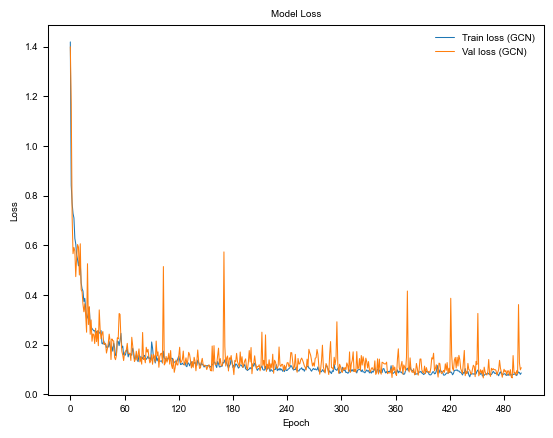

In [51]:
plot_loss(anion_gcn_train_loss, anion_gcn_val_loss)

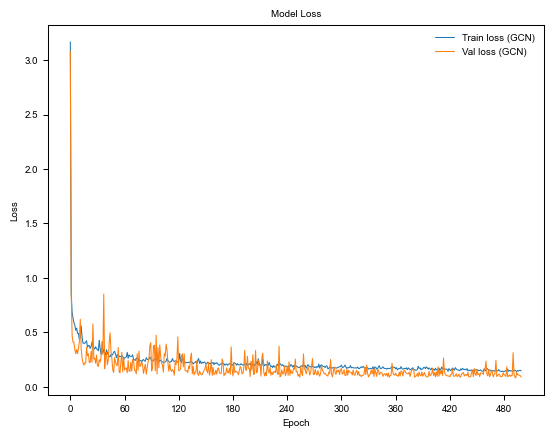

In [52]:
plot_loss(cation_gcn_train_loss, cation_gcn_val_loss)

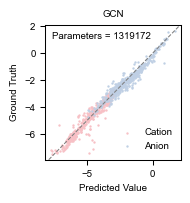

In [83]:
plot_cation_anion_targets(cation_gcn_val_pred, cation_gcn_val_true, anion_gcn_val_pred,
                          anion_gcn_val_true, title="GCN", save_path="GCN_cation_anion_val.png")

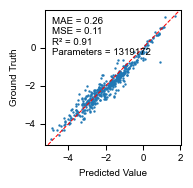

In [54]:
plot_targets(anion_gcn_val_pred, anion_gcn_val_true, anion_gcn_mse, anion_gcn_mae, save_path="anion_GCN_val_HOMO.png")

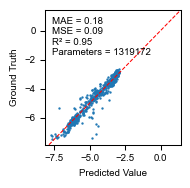

In [55]:
plot_targets(cation_gcn_val_pred, cation_gcn_val_true, cation_gcn_mse, cation_gcn_mae, save_path="cation_GCN_val_LUMO.png")

# 25% train dataset

In [56]:
anion_25_load_train_dataset_path = 'dataset/train_anion_data_list_25.pt'
anion_25_loaded_train_data_list = load_data_list(anion_25_load_train_dataset_path)
anion_25_train_loader = DataLoader(anion_25_loaded_train_data_list, batch_size=128, shuffle=True)  

cation_25_load_train_dataset_path = 'dataset/train_cation_data_list_25.pt'
cation_25_loaded_train_data_list = load_data_list(cation_25_load_train_dataset_path)
cation_25_train_loader = DataLoader(cation_25_loaded_train_data_list, batch_size=128, shuffle=True)  

In [57]:
epochs = 500

model_anion_25 = GCN(dim_h=256).to(device)
model_cation_25 = GCN(dim_h=256).to(device)

In [58]:
anion_gcn_train_loss_25, anion_gcn_val_loss_25, anion_gcn_train_pred_25, anion_gcn_train_true_25, anion_gcn_val_pred_25, anion_gcn_val_true_25, anion_gcn_mse_25, anion_gcn_mae_25 = train_epochs(
    11, epochs,model_anion_25, anion_25_train_loader, anion_val_loader, "Anion_GCN_model_HOMO_25.pt"
)

Epoch: 0, Train loss: 2.2723, Val loss: 1.1604
Epoch: 2, Train loss: 1.0768, Val loss: 1.0301
Epoch: 4, Train loss: 0.9152, Val loss: 1.4736
Epoch: 6, Train loss: 0.8089, Val loss: 1.2647
Epoch: 8, Train loss: 0.7491, Val loss: 1.0682
Epoch: 10, Train loss: 0.7399, Val loss: 0.8018
Epoch: 12, Train loss: 0.7223, Val loss: 0.5996
Epoch: 14, Train loss: 0.6366, Val loss: 0.5538
Epoch: 16, Train loss: 0.6295, Val loss: 0.6657
Epoch: 18, Train loss: 0.6507, Val loss: 0.6327
Epoch: 20, Train loss: 0.5851, Val loss: 0.4808
Epoch: 22, Train loss: 0.5463, Val loss: 0.5242
Epoch: 24, Train loss: 0.5554, Val loss: 0.4939
Epoch: 26, Train loss: 0.4951, Val loss: 0.4365
Epoch: 28, Train loss: 0.7438, Val loss: 0.4363
Epoch: 30, Train loss: 0.5885, Val loss: 0.7298
Epoch: 32, Train loss: 0.7090, Val loss: 0.4691
Epoch: 34, Train loss: 0.6472, Val loss: 0.5549
Epoch: 36, Train loss: 0.5272, Val loss: 0.4762
Epoch: 38, Train loss: 0.4252, Val loss: 0.4101
Epoch: 40, Train loss: 0.3622, Val loss: 0.42

In [59]:
cation_gcn_train_loss_25, cation_gcn_val_loss_25, cation_gcn_train_pred_25, cation_gcn_train_true_25, cation_gcn_val_pred_25, cation_gcn_val_true_25, cation_gcn_mse_25, cation_gcn_mae_25 = train_epochs(
    12, epochs,model_cation_25, cation_25_train_loader, cation_val_loader, "Cation_GCN_model_LUMO_25.pt"
)

Epoch: 0, Train loss: 8.3342, Val loss: 2.5930
Epoch: 2, Train loss: 1.5384, Val loss: 2.6741
Epoch: 4, Train loss: 0.9314, Val loss: 0.8313
Epoch: 6, Train loss: 0.8549, Val loss: 0.7031
Epoch: 8, Train loss: 0.6482, Val loss: 0.5009
Epoch: 10, Train loss: 0.6022, Val loss: 0.5262
Epoch: 12, Train loss: 0.5784, Val loss: 0.4932
Epoch: 14, Train loss: 0.5590, Val loss: 0.4685
Epoch: 16, Train loss: 0.5137, Val loss: 0.4037
Epoch: 18, Train loss: 0.5584, Val loss: 0.4224
Epoch: 20, Train loss: 0.4880, Val loss: 0.4230
Epoch: 22, Train loss: 0.4460, Val loss: 0.3501
Epoch: 24, Train loss: 0.4882, Val loss: 0.3334
Epoch: 26, Train loss: 0.4738, Val loss: 0.4395
Epoch: 28, Train loss: 0.4493, Val loss: 0.3164
Epoch: 30, Train loss: 0.4370, Val loss: 0.3232
Epoch: 32, Train loss: 0.4503, Val loss: 0.3812
Epoch: 34, Train loss: 0.4301, Val loss: 0.3791
Epoch: 36, Train loss: 0.4252, Val loss: 0.3114
Epoch: 38, Train loss: 0.3876, Val loss: 0.3255
Epoch: 40, Train loss: 0.3837, Val loss: 0.26

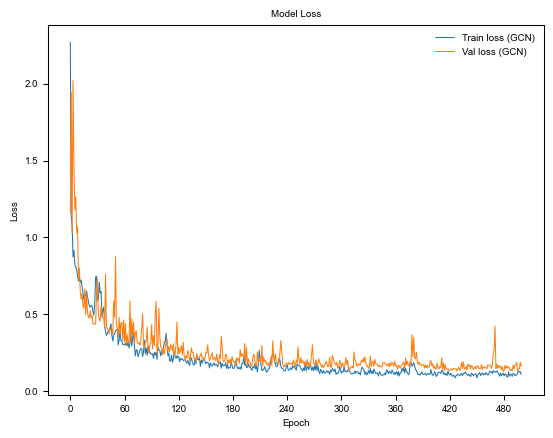

In [60]:
plot_loss(anion_gcn_train_loss_25, anion_gcn_val_loss_25)

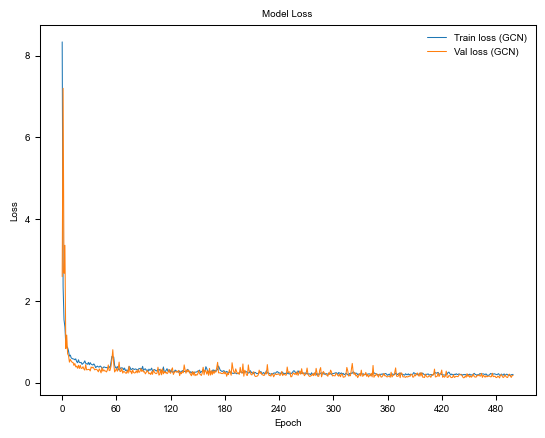

In [61]:
plot_loss(cation_gcn_train_loss_25, cation_gcn_val_loss_25)

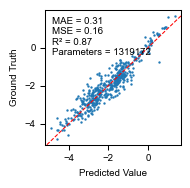

In [62]:
plot_targets(anion_gcn_val_pred_25, anion_gcn_val_true_25, anion_gcn_mse_25, anion_gcn_mae_25, save_path="anion_GCN_val_25.png")

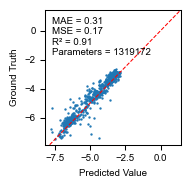

In [63]:
plot_targets(cation_gcn_val_pred_25, cation_gcn_val_true_25, cation_gcn_mse_25, cation_gcn_mae_25, save_path="cation_GCN_val_25.png")

# 50% train dataset

In [64]:
# Load the anion training set
anion_50_load_train_dataset_path = 'dataset/train_anion_data_list_50.pt' # Training set
anion_50_loaded_train_data_list = load_data_list(anion_50_load_train_dataset_path)
anion_50_train_loader = DataLoader(anion_50_loaded_train_data_list, batch_size=128, shuffle=True)  

# Load the cation training set
cation_50_load_train_dataset_path = 'dataset/train_cation_data_list_50.pt' # Training set
cation_50_loaded_train_data_list = load_data_list(cation_50_load_train_dataset_path)
cation_50_train_loader = DataLoader(cation_50_loaded_train_data_list, batch_size=128, shuffle=True)  

In [65]:
model_anion_50 = GCN(dim_h=256).to(device)
model_cation_50 = GCN(dim_h=256).to(device)

In [66]:
anion_gcn_train_loss_50, anion_gcn_val_loss_50, anion_gcn_train_pred_50, anion_gcn_train_true_50, anion_gcn_val_pred_50, anion_gcn_val_true_50, anion_gcn_mse_50, anion_gcn_mae_50 = train_epochs(
    11, epochs,model_anion_50, anion_50_train_loader, anion_val_loader, "Anion_GCN_model_HOMO_50.pt"
)

Epoch: 0, Train loss: 1.8709, Val loss: 1.8207
Epoch: 2, Train loss: 0.8510, Val loss: 0.9786
Epoch: 4, Train loss: 0.7482, Val loss: 0.9222
Epoch: 6, Train loss: 0.6896, Val loss: 0.6318
Epoch: 8, Train loss: 0.6231, Val loss: 0.5187
Epoch: 10, Train loss: 0.6225, Val loss: 0.6519
Epoch: 12, Train loss: 0.6811, Val loss: 0.5457
Epoch: 14, Train loss: 0.6330, Val loss: 0.4789
Epoch: 16, Train loss: 0.5240, Val loss: 0.4937
Epoch: 18, Train loss: 0.5199, Val loss: 0.4196
Epoch: 20, Train loss: 0.5718, Val loss: 0.4274
Epoch: 22, Train loss: 0.4458, Val loss: 0.4062
Epoch: 24, Train loss: 0.4374, Val loss: 0.3424
Epoch: 26, Train loss: 0.4205, Val loss: 0.3479
Epoch: 28, Train loss: 0.3894, Val loss: 0.3225
Epoch: 30, Train loss: 0.3780, Val loss: 0.4554
Epoch: 32, Train loss: 0.4183, Val loss: 0.3844
Epoch: 34, Train loss: 0.3566, Val loss: 0.4301
Epoch: 36, Train loss: 0.4157, Val loss: 0.4059
Epoch: 38, Train loss: 0.2722, Val loss: 0.3636
Epoch: 40, Train loss: 0.3206, Val loss: 0.32

In [67]:
cation_gcn_train_loss_50, cation_gcn_val_loss_50, cation_gcn_train_pred_50, cation_gcn_train_true_50, cation_gcn_val_pred_50, cation_gcn_val_true_50, cation_gcn_mse_50, cation_gcn_mae_50 = train_epochs(
    12, epochs,model_cation_50, cation_50_train_loader, cation_val_loader, "Cation_GCN_model_LUMO_50.pt"
)

Epoch: 0, Train loss: 5.4503, Val loss: 11.9471
Epoch: 2, Train loss: 0.9967, Val loss: 1.0812
Epoch: 4, Train loss: 0.7095, Val loss: 0.5080
Epoch: 6, Train loss: 0.6613, Val loss: 0.8494
Epoch: 8, Train loss: 0.5592, Val loss: 0.4288
Epoch: 10, Train loss: 0.5559, Val loss: 0.3870
Epoch: 12, Train loss: 0.5400, Val loss: 0.4296
Epoch: 14, Train loss: 0.5094, Val loss: 0.3854
Epoch: 16, Train loss: 0.4562, Val loss: 0.3758
Epoch: 18, Train loss: 0.4392, Val loss: 0.2963
Epoch: 20, Train loss: 0.4811, Val loss: 0.3130
Epoch: 22, Train loss: 0.4753, Val loss: 0.5204
Epoch: 24, Train loss: 0.5245, Val loss: 0.2861
Epoch: 26, Train loss: 0.4755, Val loss: 0.3582
Epoch: 28, Train loss: 0.3950, Val loss: 0.3847
Epoch: 30, Train loss: 0.3959, Val loss: 0.2348
Epoch: 32, Train loss: 0.3512, Val loss: 0.2809
Epoch: 34, Train loss: 0.3868, Val loss: 0.2257
Epoch: 36, Train loss: 0.3492, Val loss: 0.2411
Epoch: 38, Train loss: 0.3687, Val loss: 0.2343
Epoch: 40, Train loss: 0.3684, Val loss: 0.2

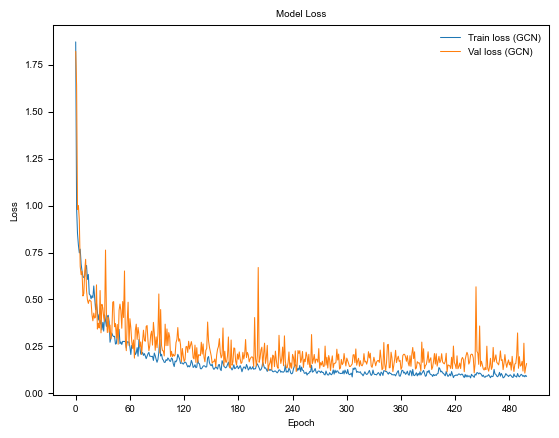

In [68]:
plot_loss(anion_gcn_train_loss_50, anion_gcn_val_loss_50)

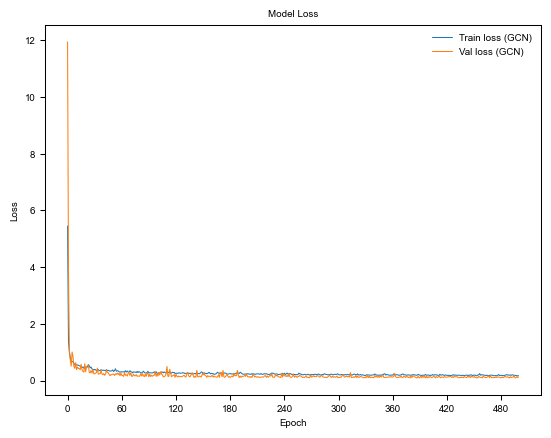

In [69]:
plot_loss(cation_gcn_train_loss_50, cation_gcn_val_loss_50)

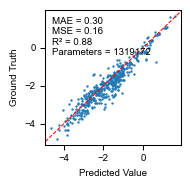

In [70]:
plot_targets(anion_gcn_val_pred_50, anion_gcn_val_true_50, anion_gcn_mse_50, anion_gcn_mae_50, save_path="anion_GCN_val_50.png")

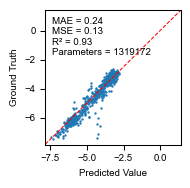

In [71]:
plot_targets(cation_gcn_val_pred_50, cation_gcn_val_true_50, cation_gcn_mse_50, cation_gcn_mae_50, save_path="cation_GCN_val_50.png")

# 75% train dataset

In [72]:
# Load the anion training set
anion_75_load_train_dataset_path = 'dataset/train_anion_data_list_75.pt' # Training set
anion_75_loaded_train_data_list = load_data_list(anion_75_load_train_dataset_path)
anion_75_train_loader = DataLoader(anion_75_loaded_train_data_list, batch_size=128, shuffle=True)  

# Load the cation training set
cation_75_load_train_dataset_path = 'dataset/train_cation_data_list_75.pt' # Training set
cation_75_loaded_train_data_list = load_data_list(cation_75_load_train_dataset_path)
cation_75_train_loader = DataLoader(cation_75_loaded_train_data_list, batch_size=128, shuffle=True)  

In [73]:
model_anion_75 = GCN(dim_h=256).to(device)
model_cation_75 = GCN(dim_h=256).to(device)

In [74]:
anion_gcn_train_loss_75, anion_gcn_val_loss_75, anion_gcn_train_pred_75, anion_gcn_train_true_75, anion_gcn_val_pred_75, anion_gcn_val_true_75, anion_gcn_mse_75, anion_gcn_mae_75 = train_epochs(
    11, epochs,model_anion_75, anion_75_train_loader, anion_val_loader, "Anion_GCN_model_HOMO_75.pt"
)

Epoch: 0, Train loss: 1.3220, Val loss: 2.1921
Epoch: 2, Train loss: 0.8546, Val loss: 0.7651
Epoch: 4, Train loss: 0.7394, Val loss: 0.6870
Epoch: 6, Train loss: 0.6924, Val loss: 0.6576
Epoch: 8, Train loss: 0.5952, Val loss: 0.4792
Epoch: 10, Train loss: 0.5784, Val loss: 0.6583
Epoch: 12, Train loss: 0.5557, Val loss: 0.4518
Epoch: 14, Train loss: 0.4725, Val loss: 0.3869
Epoch: 16, Train loss: 0.4969, Val loss: 0.4373
Epoch: 18, Train loss: 0.5047, Val loss: 0.5249
Epoch: 20, Train loss: 0.3942, Val loss: 0.3854
Epoch: 22, Train loss: 0.3609, Val loss: 0.4062
Epoch: 24, Train loss: 0.3511, Val loss: 0.2712
Epoch: 26, Train loss: 0.3173, Val loss: 0.3226
Epoch: 28, Train loss: 0.2994, Val loss: 0.6318
Epoch: 30, Train loss: 0.3184, Val loss: 0.2821
Epoch: 32, Train loss: 0.2874, Val loss: 0.3738
Epoch: 34, Train loss: 0.2554, Val loss: 0.3694
Epoch: 36, Train loss: 0.3362, Val loss: 0.7968
Epoch: 38, Train loss: 0.2770, Val loss: 0.3495
Epoch: 40, Train loss: 0.2643, Val loss: 0.22

In [75]:
cation_gcn_train_loss_75, cation_gcn_val_loss_75, cation_gcn_train_pred_75, cation_gcn_train_true_75, cation_gcn_val_pred_75, cation_gcn_val_true_75, cation_gcn_mse_75, cation_gcn_mae_75 = train_epochs(
    12, epochs,model_cation_75, cation_75_train_loader, cation_val_loader, "Cation_GCN_model_LUMO_75.pt"
)

Epoch: 0, Train loss: 3.3195, Val loss: 2.5714
Epoch: 2, Train loss: 0.7585, Val loss: 1.5903
Epoch: 4, Train loss: 0.6372, Val loss: 0.4096
Epoch: 6, Train loss: 0.5728, Val loss: 0.4665
Epoch: 8, Train loss: 0.5109, Val loss: 0.4921
Epoch: 10, Train loss: 0.5209, Val loss: 0.3320
Epoch: 12, Train loss: 0.4630, Val loss: 0.2803
Epoch: 14, Train loss: 0.4244, Val loss: 0.3045
Epoch: 16, Train loss: 0.4520, Val loss: 0.2649
Epoch: 18, Train loss: 0.3895, Val loss: 0.2353
Epoch: 20, Train loss: 0.3969, Val loss: 0.3898
Epoch: 22, Train loss: 0.3834, Val loss: 0.3265
Epoch: 24, Train loss: 0.3801, Val loss: 0.2180
Epoch: 26, Train loss: 0.3703, Val loss: 0.3479
Epoch: 28, Train loss: 0.3852, Val loss: 0.2103
Epoch: 30, Train loss: 0.3273, Val loss: 0.1875
Epoch: 32, Train loss: 0.3682, Val loss: 0.2549
Epoch: 34, Train loss: 0.3239, Val loss: 0.1651
Epoch: 36, Train loss: 0.3258, Val loss: 0.1798
Epoch: 38, Train loss: 0.3288, Val loss: 0.2461
Epoch: 40, Train loss: 0.3186, Val loss: 0.19

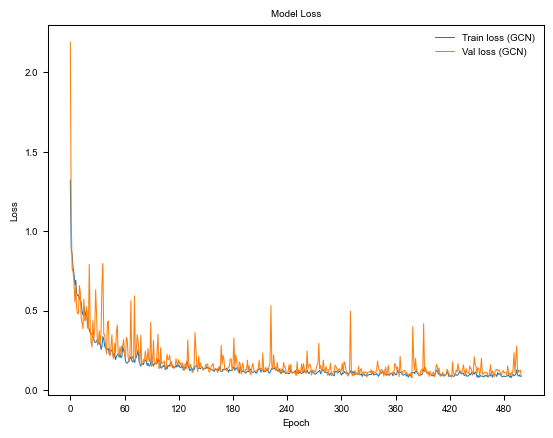

In [76]:
plot_loss(anion_gcn_train_loss_75, anion_gcn_val_loss_75)

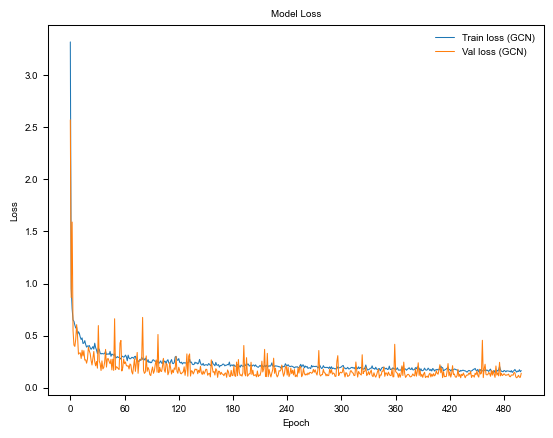

In [77]:
plot_loss(cation_gcn_train_loss_75, cation_gcn_val_loss_75)

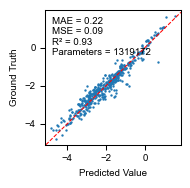

In [78]:
plot_targets(anion_gcn_val_pred_75, anion_gcn_val_true_75, anion_gcn_mse_75, anion_gcn_mae_75, save_path="anion_GCN_val_75.png")

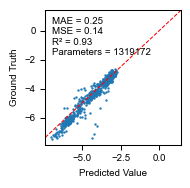

In [79]:
plot_targets(cation_gcn_val_pred_75, cation_gcn_val_true_75, cation_gcn_mse_75, cation_gcn_mae_75, save_path="cation_GCN_val_75.png")